In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
all_data = []
file_paths = ['data/results_ortools.txt', 'data/results_cplex_cp.txt', 'data/results_cplex_lp.txt', 'data/results_gurobi.txt', 'data/results_hexaly.txt', 'data/results_ga_best.txt', 'data/results_ga_median.txt']
optimizers = ['ORTOOLS', 'CPLEX-CP', 'CPLEX-LP', 'GUROBI', 'HEXALY', 'GA-BEST', 'GA-MEDIAN']
# testing
#file_paths = [r'C:\Users\huda\Downloads\results_ortools.txt', r'C:\Users\huda\Downloads\results_cplex_cp.txt']
file_paths = [r'C:\Users\huda\Downloads\results_ortools.txt', r'C:\Users\huda\Downloads\results_cplex_cp.txt', r'C:\Users\huda\Downloads\results_gurobi.txt', r'C:\Users\huda\Downloads\results_hexaly.txt']
optimizers = ['ORTOOLS', 'CPLEX-CP', 'GUROBI', 'HEXALY']

In [6]:
def read_file(file : str) -> pd.DataFrame:
    file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    # NOTE: fill optimization status for GA versions with 0
    #file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value', 'runtime', 'resource_history', 'best_result_history'], sep=';')
    df = pd.DataFrame(file_content)
    df.drop(columns=['lower_bound', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram'])
    return df[~df['name'].str.startswith('Error')]

In [7]:
# convert GA result file
import json
import copy
main_path = r'C:\Users\huda\Downloads\OneDrive_1_9-27-2024'
import os
ga_files = [f for f in os.listdir(main_path)]
out_path = 'data/results_ga_best.txt'
#best = dict()
for instance in ga_files:
    with open(f'{main_path}\\{instance}', 'r') as file:
        #file_congtent = file.read()
        data = json.loads(f'[{file.read()}]')
        name = data[0]['name']
        best= copy.deepcopy(data[0])
        for run in data[1:]:
            if run['Result']['Fitness']['Makespan'] < best['Result']['Fitness']['Makespan']:
                best = copy.deepcopy(run)
        del data
        optimization_status = 0
        fitness_value = best['Result']['Fitness']['Makespan']
        lower_bound = 0
        runtime = best['Result']['TimeInSeconds']
        result_vector1 = best['Result']['Sequence']
        result_vector2 = best['Result']['Assignments']
        result_vector3 = best['Result']['Workers']
        peak_cpu = 0.0 # TODO
        peak_ram = 0.0 # TODO
        resource_history = [] 
        best_result_history = best['OverallBestFitness']

        with open(out_path, 'a') as out:
            out.write(f'{name};{optimization_status};{fitness_value};{lower_bound};{runtime};{result_vector1};{result_vector2};{result_vector3};{peak_cpu};{peak_ram};{resource_history};{best_result_history}')


JSONDecodeError: Expecting ',' delimiter: line 1 column 835484 (char 835483)

In [8]:
for file in file_paths:
    all_data.append(read_file(file))

In [9]:
def get_comparison(data, instance):
    best = -float('inf')
    for optimizer in data:
        fitness = optimizer.loc[optimizer['name'] == instance]['lower_bound']
        if len(fitness.tolist()) > 1:
            fitness = fitness.tolist()[1]
        elif len(fitness.tolist()) == 0:
            fitness = 2 * best
        else:
            fitness = fitness.tolist()[0]
        if fitness > best:
            best = fitness
    return best

def calculate_value(fitness, best):
    return ((fitness - best) / best)# * 100

def skip(data, instance):
    for optimizer in data:
        if not instance in optimizer.name.values:
            return True
    return False

def get_cdf_comparison_vector(data : dict, column):
    # TODO: handle missing results (handling done, but not really tested)
    results = []
    for optimizer in data:
        #print(optimizer)
        results.append([])
    
    for index, row in data[0].iterrows():
        instance = row['name']
        if not skip(data, instance):
            best = get_comparison(data, instance)
            i = 0
            for optimizer in data:
                # TODO: should technically work - only in use when no skipping is used
                if not instance in optimizer.name.values:
                    #results[i].append(calculate_value(2 * best, best))
                    #results[i].append(float('inf'))
                    pass
                else:
                    results[i].append(calculate_value(optimizer.loc[optimizer['name'] == instance][column], best).item())
                i += 1
    for result in results:
        result.sort()
    return results

In [10]:
result_vectors = get_cdf_comparison_vector(all_data, 'lower_bound')

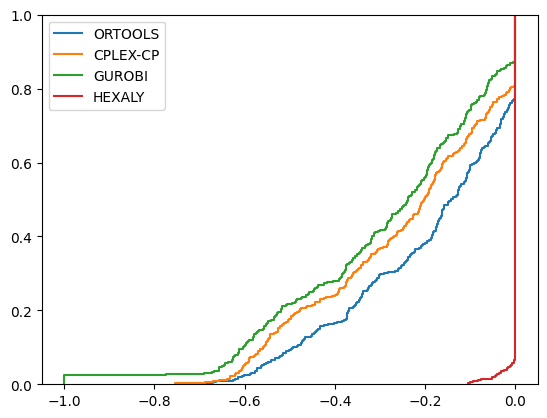

In [11]:
for i in range(len(result_vectors)):
    plt.ecdf(result_vectors[i], label=optimizers[i])
plt.title('Lower Bound')
plt.legend()
plt.show()

In [12]:
def get_comparison(data, instance):
    best = float('inf')
    for optimizer in data:
        fitness = optimizer.loc[optimizer['name'] == instance]['fitness_value']
        if len(fitness.tolist()) > 1:
            fitness = fitness.tolist()[1]
        elif len(fitness.tolist()) == 0:
            fitness = 2 * best
        else:
            fitness = fitness.tolist()[0]
        if fitness < best:
            best = fitness
    return best

def calculate_value(fitness, best):
    return ((fitness - best) / best)# * 100

def skip(data, instance):
    for optimizer in data:
        if not instance in optimizer.name.values:
            return True
    return False

def get_cdf_comparison_vector(data : dict, column):
    # TODO: handle missing results (handling done, but not really tested)
    results = []
    for optimizer in data:
        #print(optimizer)
        results.append([])
    
    for index, row in data[0].iterrows():
        instance = row['name']
        if not skip(data, instance):
            best = get_comparison(data, instance)
            i = 0
            for optimizer in data:
                # TODO: should technically work - only in use when no skipping is used
                if not instance in optimizer.name.values:
                    #results[i].append(calculate_value(2 * best, best))
                    #results[i].append(float('inf'))
                    pass
                else:
                    results[i].append(calculate_value(optimizer.loc[optimizer['name'] == instance][column], best).item())
                i += 1
    for result in results:
        result.sort()
    return results

In [13]:
result_vectors = get_cdf_comparison_vector(all_data, 'fitness_value')

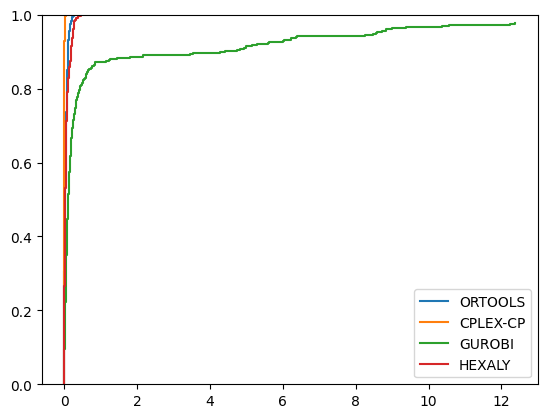

In [14]:
for i in range(len(result_vectors)):
    plt.ecdf(result_vectors[i], label=optimizers[i])
plt.title('Fitness')
plt.legend()
plt.show()

In [25]:
def get_history(df, instance):
    fitness_history = []
    timestamp_history = []
    lower_bound_history = []
    try:
        values = pd.eval(df.loc[df['name'] == instance]['best_result_history'])
        for entry in values:
            for nested_entry in entry: # ??
                timestamp_history.append(nested_entry[0])
                fitness_history.append(nested_entry[1])
                lower_bound_history.append(nested_entry[2])
    except:
        pass
    if len(fitness_history) > 0:
        fitness_history.append(fitness_history[-1])
        timestamp_history.append(1200 if timestamp_history[-1] < 1200 else timestamp_history[-1]) # max time limit
        lower_bound_history.append(lower_bound_history[-1])
    return fitness_history, timestamp_history, lower_bound_history

KeyboardInterrupt: 

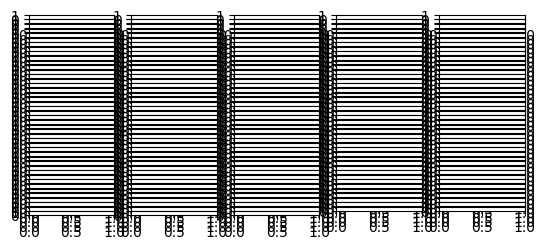

In [24]:
cols = 5
rows = 81
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(200)
fig.set_figwidth(20)

fig.suptitle(f'Fitness & Lower Bounds')
rows = all_data[-2]['name'].tolist()


index = 0
for instance in rows:
    for i in range(len(all_data)):
        data = all_data[i]
        fitness, timestamps, lower_bound = get_history(data, instance)
        if len(fitness) > 1 and fitness[1] != float('inf'):
            axs[int(index / cols), index % cols].set_ylim(0, fitness[1])
            axs[int(index / cols), index % cols].set_ylim(0, lower_bound)
            axs[int(index / cols), index % cols].plot(timestamps, fitness, linestyle='solid')
            axs[int(index / cols), index % cols].set_title(f'{instance}')
    index += 1
fig.legend(labels=optimizers, loc='upper right')
fig.tight_layout()